# Multistate Model for AIDS SI Data: Real-Data Example

This notebook demonstrates the use of MultiStateNN with real AIDSSI dataset. The dataset contains information about patients transitioning between HIV states and developing AIDS.

## Setup and Data Loading

First, let's import the necessary packages and load the data.

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Import MultiStateNN package
from multistate_nn import (
    fit,
    plot_transition_heatmap, 
    plot_transition_graph, 
    simulate_patient_trajectory,
    simulate_cohort_trajectories,
    calculate_cif,
    plot_cif,
    compare_cifs
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Creating AIDSSI Dataset

Since there might be compatibility issues with importing the AIDSSI dataset from pymsm, we'll create a simplified version of the dataset directly.

In [2]:
# Create a synthetic dataset based on the AIDSSI structure
# The real dataset contains transitions between 4 states:
# 0: HIV-, 1: HIV+, 2: AIDS, 3: Death

# Define state labels
state_labels = {0: "HIV-", 1: "HIV+", 2: "AIDS", 3: "Death"}

# Set the size of the dataset
n_samples = 500

# Create synthetic data
np.random.seed(42)

# Create patient IDs
patient_ids = np.repeat(np.arange(n_samples // 2), 2)  # Each patient has ~2 transitions

# Create time points (0 to 5)
times = np.random.randint(0, 6, n_samples)

# Create state transitions following a typical progression
from_states = np.random.choice([0, 1, 2], n_samples, p=[0.3, 0.5, 0.2])
to_states = np.zeros(n_samples, dtype=int)

# Define transition logic: HIV- can go to HIV+, HIV+ can go to AIDS, AIDS can go to Death
for i in range(n_samples):
    if from_states[i] == 0:  # HIV-
        to_states[i] = np.random.choice([0, 1], p=[0.8, 0.2])  # Most stay HIV-, some progress to HIV+
    elif from_states[i] == 1:  # HIV+
        to_states[i] = np.random.choice([1, 2], p=[0.7, 0.3])  # Most stay HIV+, some progress to AIDS
    elif from_states[i] == 2:  # AIDS
        to_states[i] = np.random.choice([2, 3], p=[0.6, 0.4])  # Some stay in AIDS, others progress to Death

# Create covariates
age = np.random.normal(35, 10, n_samples)  # Age (years)
cd4 = np.random.normal(500, 200, n_samples)  # CD4 count
cd4[from_states == 1] = np.random.normal(350, 150, np.sum(from_states == 1))  # Lower CD4 for HIV+
cd4[from_states == 2] = np.random.normal(200, 100, np.sum(from_states == 2))  # Even lower CD4 for AIDS
ccr5 = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])  # CCR5 mutation (present/absent)
viral_load = np.zeros(n_samples)  # Viral load
viral_load[from_states == 1] = np.random.normal(10000, 5000, np.sum(from_states == 1))
viral_load[from_states == 2] = np.random.normal(50000, 20000, np.sum(from_states == 2))

# Create the dataset
aidssi_df = pd.DataFrame({
    "patient_id": patient_ids,
    "time": times,
    "from_state": from_states,
    "to_state": to_states,
    "age": age,
    "cd4": cd4,
    "ccr5": ccr5,
    "viral_load": viral_load,
})

# Define covariates list
covariate_cols = ["age", "cd4", "ccr5", "viral_load"]

# Display the dataset
aidssi_df.head()

,patient_id,time,from_state,to_state,age,cd4,ccr5,viral_load
0,0,3,0,0,38.992231,564.633543,0,0.000000
1,0,4,1,2,41.471959,421.453665,1,6207.523326
2,1,2,1,1,30.168135,425.820524,0,12975.147329
3,1,4,1,1,50.739868,509.031486,0,7212.884734
4,2,4,1,1,22.742343,763.949006,0,7935.010889


## Understanding the Dataset

Let's explore the dataset structure and the state transition definitions.

In [3]:
# Print information about the dataset
print(f"Number of samples: {len(aidssi_df)}")
print(f"Covariates: {covariate_cols}")
print(f"State labels: {state_labels}")

Number of samples: 500
Covariates: ['age', 'cd4', 'ccr5', 'viral_load']
State labels: {0: 'HIV-', 1: 'HIV+', 2: 'AIDS', 3: 'Death'}


Transition Count Matrix:


to_state,0,1,2,3
from_state,,,,
0,118,29,0,0
1,0,174,72,0
2,0,0,68,39


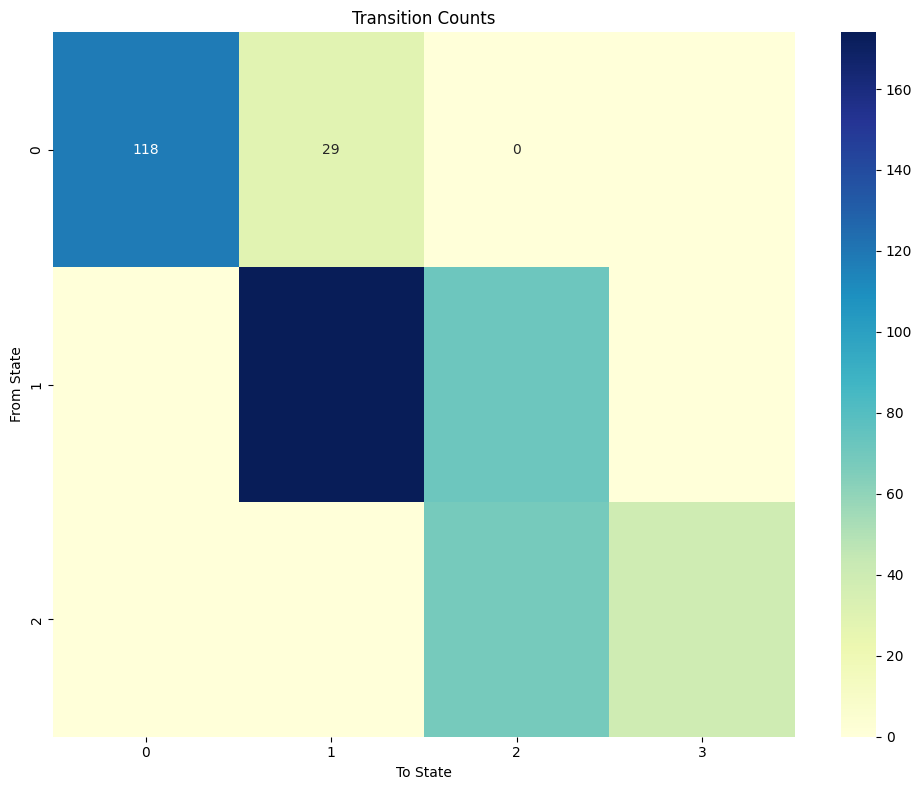

In [4]:
# Let's examine the distribution of transitions
transition_counts = aidssi_df.groupby(['from_state', 'to_state']).size().reset_index(name='count')
transition_pivot = transition_counts.pivot(index='from_state', columns='to_state', values='count').fillna(0).astype(int)

# Display the transition count matrix
print("Transition Count Matrix:")
display(transition_pivot)

# Plot the transition counts as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transition_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Transition Counts')
plt.xlabel('To State')
plt.ylabel('From State')
plt.tight_layout()
plt.show()

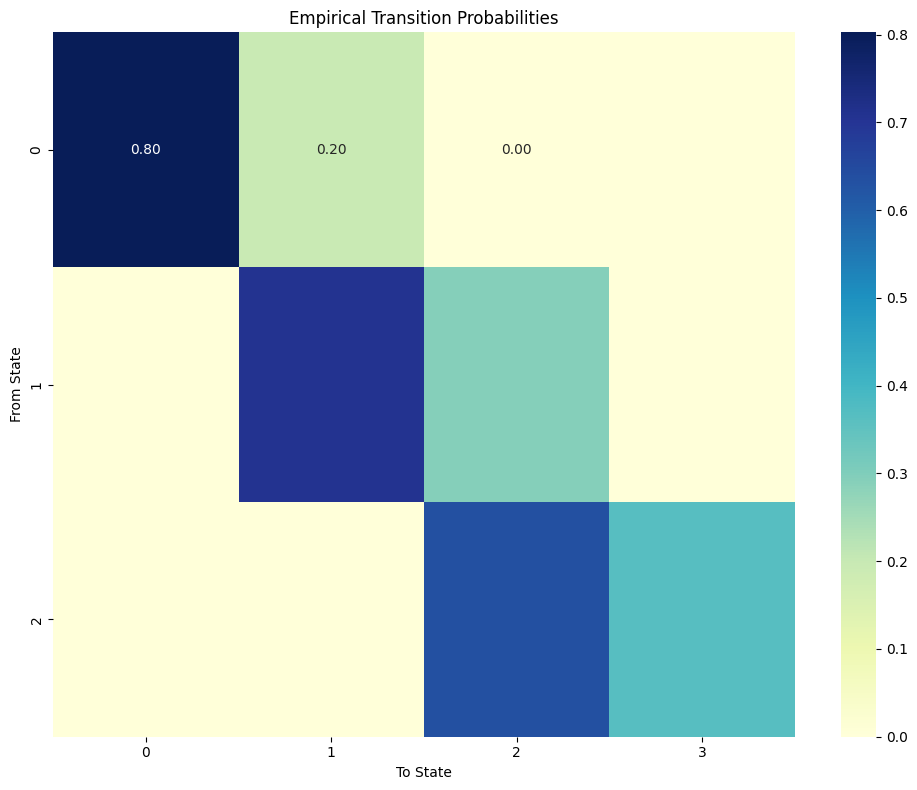

In [5]:
# Calculate the transition probabilities
transition_probs = transition_pivot.div(transition_pivot.sum(axis=1), axis=0)

# Plot the transition probabilities as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transition_probs, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Empirical Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.tight_layout()
plt.show()

## Preparing Data for the Multistate Model

Based on the data exploration, we need to define the state transition structure for our model.

In [6]:
# Get unique states
unique_from_states = aidssi_df['from_state'].unique()
unique_to_states = aidssi_df['to_state'].unique()
all_states = np.unique(np.concatenate([unique_from_states, unique_to_states]))

# Define state transition structure based on observed transitions
state_transitions = {}
for state in all_states:
    transitions_from_state = aidssi_df[aidssi_df['from_state'] == state]['to_state'].unique()
    state_transitions[int(state)] = [int(s) for s in transitions_from_state]

# Display the state transition structure
for from_state, to_states in state_transitions.items():
    if to_states:
        print(f"From state {from_state} ({state_labels[from_state]}): Can transition to states {to_states} ({[state_labels[s] for s in to_states]})")
    else:
        print(f"State {from_state} ({state_labels[from_state]}): Absorbing state (no outgoing transitions)")

From state 0 (HIV-): Can transition to states [0, 1] (['HIV-', 'HIV+'])
From state 1 (HIV+): Can transition to states [2, 1] (['AIDS', 'HIV+'])
From state 2 (AIDS): Can transition to states [3, 2] (['Death', 'AIDS'])
State 3 (Death): Absorbing state (no outgoing transitions)


In [7]:
# Prepare the data - scale the numerical covariates
df = aidssi_df.copy()

# Ensure all categorical covariates are properly encoded
categorical_cols = ["ccr5"]
numerical_cols = [col for col in covariate_cols if col not in categorical_cols]

# Scale numerical covariates
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,patient_id,time,from_state,to_state,age,cd4,ccr5,viral_load
0,0,3,0,0,0.303257,1.070577,0,-0.743030
1,0,4,1,2,0.547850,0.305894,1,-0.443717
2,1,2,1,1,-0.567128,0.329217,0,-0.117398
3,1,4,1,1,1.462012,0.773622,0,-0.395241
4,2,4,1,1,-1.299588,2.135063,0,-0.360422


## Training the MultiState Neural Network Model

In [8]:
# Define model parameters
input_dim = len(covariate_cols)
hidden_dims = [64, 32]  # Two hidden layers
num_states = int(max(all_states)) + 1

# Fit the model
model = fit(
    df=df,
    covariates=covariate_cols,
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    num_states=num_states,
    state_transitions=state_transitions,
    epochs=30,  # Fewer epochs for the example
    batch_size=32,
    learning_rate=0.001
)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

## Making Predictions for Sample Patients

Now let's make predictions for a few sample patients and analyze the results.

In [9]:
# Create test cases with different profiles
# Let's select a few patients with different covariate profiles
# First, let's get the mean and std of each covariate to generate realistic test cases
covariate_stats = df[covariate_cols].describe()
display(covariate_stats)

,age,cd4,ccr5,viral_load
count,5.000000e+02,5.000000e+02,500.000000,5.000000e+02
mean,-5.471179e-16,-2.700062e-16,0.194000,-2.131628e-17
std,1.001002e+00,1.001002e+00,0.395825,1.001002e+00
min,-2.947314e+00,-2.161972e+00,0.000000,-9.819815e-01
25%,-6.917993e-01,-6.546726e-01,0.000000,-7.430300e-01
50%,-1.385688e-02,-1.166282e-01,0.000000,-3.366814e-01
75%,6.539273e-01,5.859775e-01,0.000000,4.037673e-02
max,2.475704e+00,3.549923e+00,1.000000,3.421111e+00


In [10]:
# Get a random sample of real patients for testing
sample_patients = df.sample(5)
sample_patients_covs = sample_patients[covariate_cols].values

# Convert to tensor
x_test = torch.tensor(sample_patients_covs, dtype=torch.float32)

# Display the sample patients
display(sample_patients)

,patient_id,time,from_state,to_state,age,cd4,ccr5,viral_load
352,176,3,0,0,0.641457,0.697183,1,-0.743030
300,150,5,0,0,-0.301060,1.743474,1,-0.743030
118,59,0,0,0,-1.068409,1.344519,1,-0.743030
182,91,2,2,3,-0.381457,-1.459872,0,0.590492
370,185,4,1,1,1.079020,0.209165,0,0.034019


In [11]:
# Function to print predicted probabilities with labels
def print_transition_probs(x, model, time_idx, from_state):
    probs = model.predict_proba(x, time_idx, from_state).detach().cpu().numpy()
    next_states = model.state_transitions[from_state]
    
    # Create DataFrame for display
    result_df = pd.DataFrame(probs, columns=[state_labels[s] for s in next_states])
    print(f"Transition probabilities from {state_labels[from_state]} state (t={time_idx}):")
    return result_df

# Let's make predictions from state 1 (HIV+) for our sample patients
try:
    from_state = 1  # HIV+
    probs_hiv = print_transition_probs(x_test, model, time_idx=0, from_state=from_state)
    display(probs_hiv)
except Exception as e:
    print(f"Error predicting from state {from_state}: {e}")
    # Try another state if the first one fails
    available_states = [s for s in state_transitions.keys() if state_transitions[s]]
    if available_states:
        from_state = available_states[0]
        print(f"Trying with state {from_state} instead...")
        probs = print_transition_probs(x_test, model, time_idx=0, from_state=from_state)
        display(probs)

Transition probabilities from HIV+ state (t=0):


,AIDS,HIV+
0,0.372621,0.627379
1,0.341557,0.658443
2,0.214077,0.785923
3,0.322353,0.677647
4,0.189957,0.810043


## Visualizing Transitions with Heatmap

Let's use the built-in visualization tools to explore the predicted transitions.

<Figure size 1200x800 with 0 Axes>

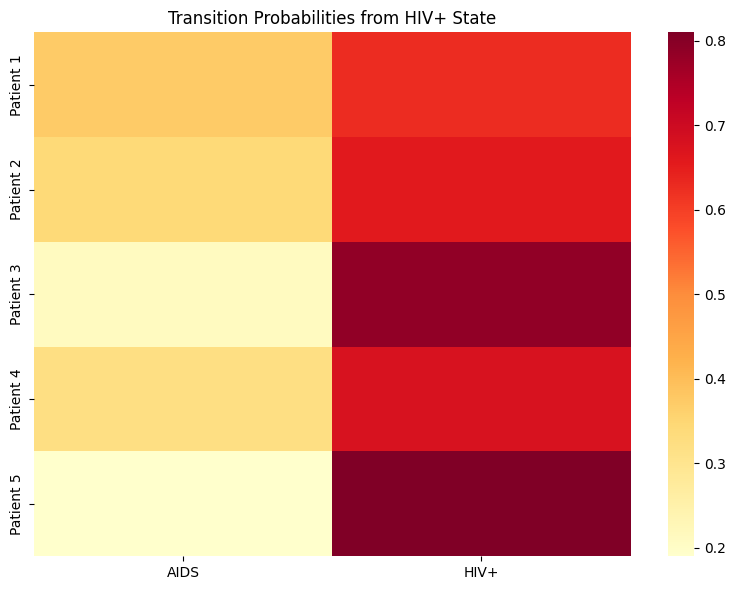

In [12]:
# Visualize transition heatmap for sample patients
plt.figure(figsize=(12, 8))
try:
    ax = plot_transition_heatmap(model, x_test, time_idx=0, from_state=from_state)
    
    # Update x-axis labels with state names
    next_states = model.state_transitions[from_state]
    ax.set_xticklabels([state_labels[s] for s in next_states])
    
    # Update y-axis labels with patient identifiers
    ax.set_yticklabels([f"Patient {i+1}" for i in range(len(x_test))])
    
    plt.title(f"Transition Probabilities from {state_labels[from_state]} State")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting transition heatmap: {e}")

## Transition Network Visualization

Let's visualize the transition network for a specific patient.

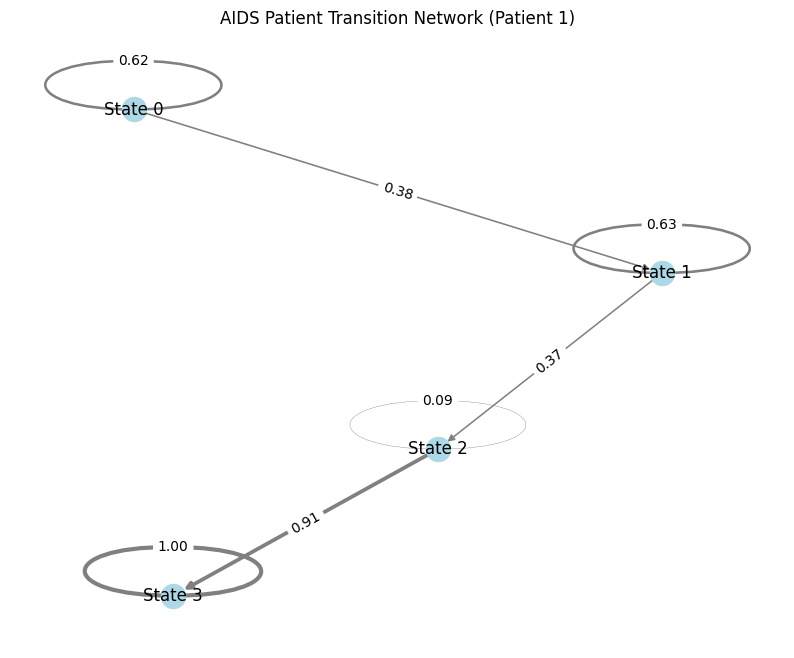

In [13]:
# Select first patient for visualization
patient1 = x_test[0:1]

try:
    fig, ax = plot_transition_graph(model, patient1, time_idx=0, threshold=0.01)
    plt.title(f"AIDS Patient Transition Network (Patient 1)")
    plt.show()
except Exception as e:
    print(f"Error plotting transition graph: {e}")

## Simulating Patient Trajectories

Now, let's simulate patient trajectories to better understand the disease progression over time.

Simulating trajectories starting from state 0 (HIV-)


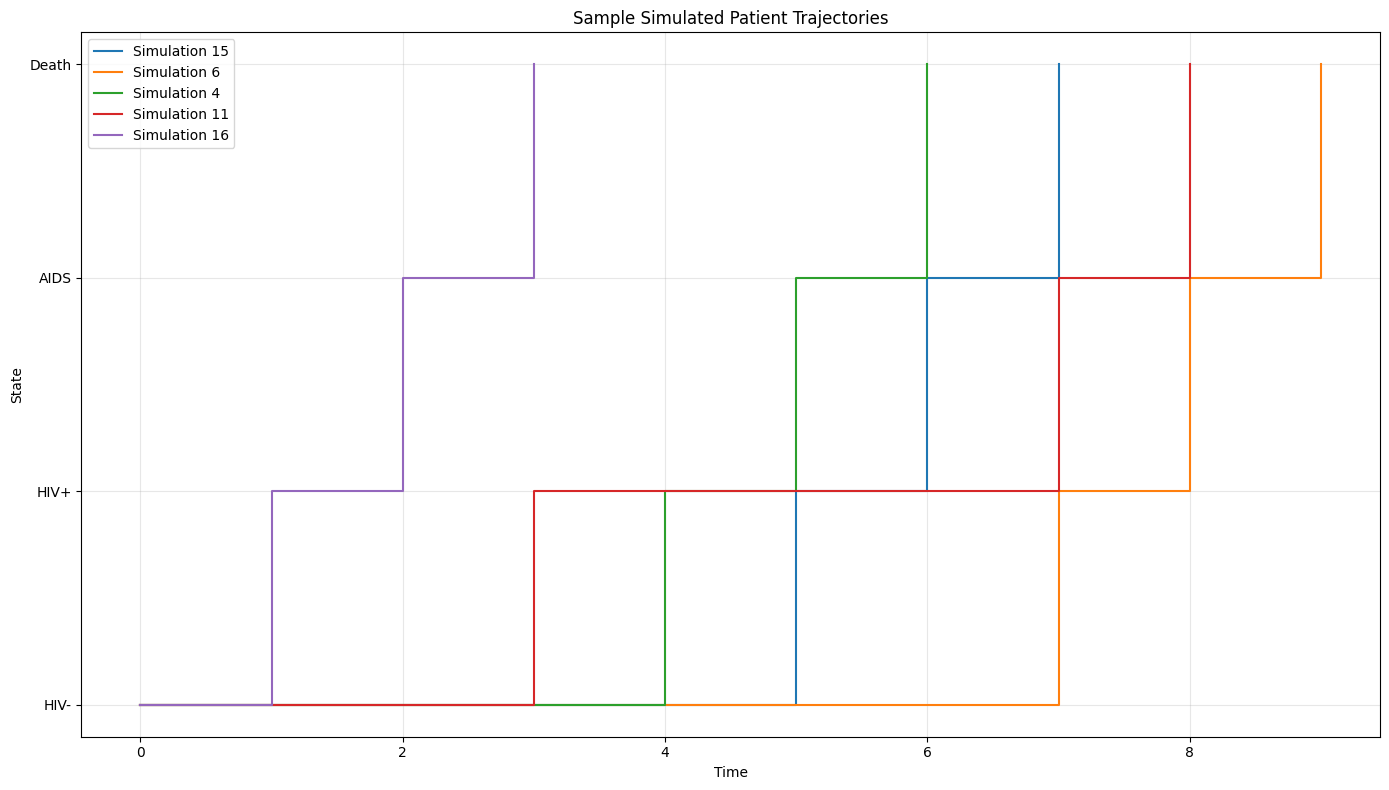

In [14]:
# Simulate trajectories for the first patient
try:
    # Choose a valid starting state that has transitions
    available_start_states = [s for s in state_transitions.keys() if state_transitions[s]]
    start_state = available_start_states[0] if available_start_states else 0
    
    max_time = 10
    n_simulations = 20
    
    print(f"Simulating trajectories starting from state {start_state} ({state_labels[start_state]})")
    
    trajectories = simulate_patient_trajectory(
        model=model, 
        x=patient1, 
        start_state=start_state, 
        max_time=max_time, 
        n_simulations=n_simulations,
        seed=42
    )
    
    # Combine all trajectories
    all_trajectories = pd.concat(trajectories, ignore_index=True)
    
    # Plot a few sample trajectories
    plt.figure(figsize=(14, 8))
    
    # Select 5 random simulations to plot
    sample_sims = np.random.choice(n_simulations, min(5, n_simulations), replace=False)
    
    for sim_idx in sample_sims:
        sim_data = all_trajectories[all_trajectories['simulation'] == sim_idx]
        plt.step(sim_data['time'], sim_data['state'], where='post', label=f'Simulation {sim_idx+1}')
    
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.yticks(list(state_labels.keys()), [state_labels[s] for s in state_labels.keys()])
    plt.title('Sample Simulated Patient Trajectories')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error simulating patient trajectories: {e}")

## Calculating Cumulative Incidence Functions (CIFs)

Let's calculate the cumulative incidence functions for reaching various states.

Calculating CIF for target state 1 (HIV+)


<Figure size 1000x600 with 0 Axes>

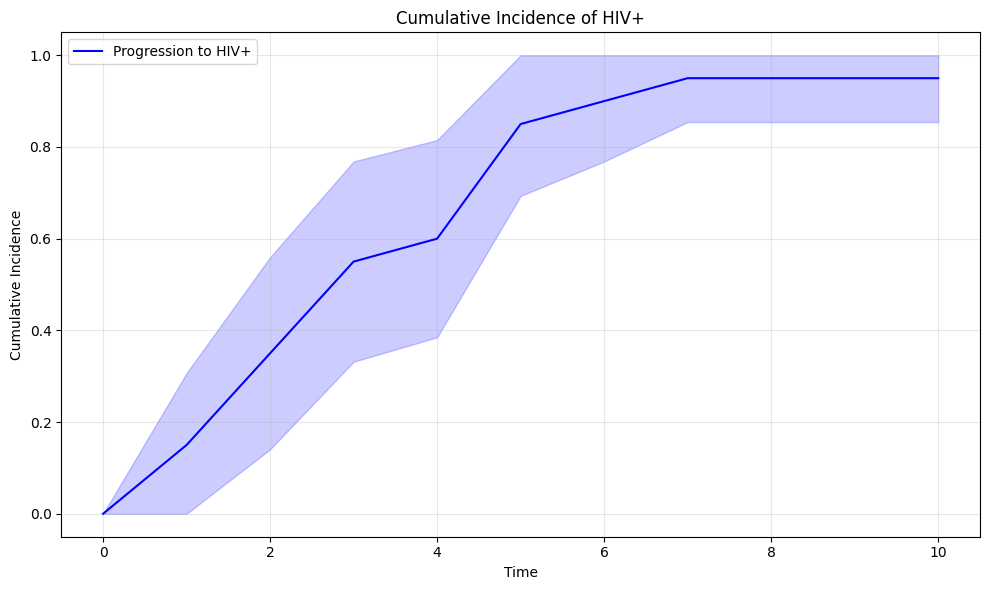

In [15]:
try:
    # Calculate CIF for reaching a target state from simulated trajectories
    # Choose a target state that's not the start state
    target_states = [s for s in all_states if s != start_state]
    target_state = target_states[0] if target_states else 2  # Default to AIDS if no valid target
    
    print(f"Calculating CIF for target state {target_state} ({state_labels[target_state]})")
    
    # Ensure we have all_trajectories available
    if 'all_trajectories' not in locals():
        trajectories = simulate_patient_trajectory(
            model=model, 
            x=patient1, 
            start_state=start_state, 
            max_time=max_time, 
            n_simulations=n_simulations,
            seed=42
        )
        
        all_trajectories = pd.concat(trajectories, ignore_index=True)
    
    # Calculate CIF
    cif_df = calculate_cif(
        trajectories=all_trajectories,
        target_state=target_state,
        max_time=max_time
    )
    
    # Plot CIF
    plt.figure(figsize=(10, 6))
    ax = plot_cif(
        cif_df=cif_df,
        label=f"Progression to {state_labels[target_state]}"
    )
    plt.title(f"Cumulative Incidence of {state_labels[target_state]}")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error calculating CIF: {e}")

## Comparing Different Patients

Let's compare CIFs for different patients.

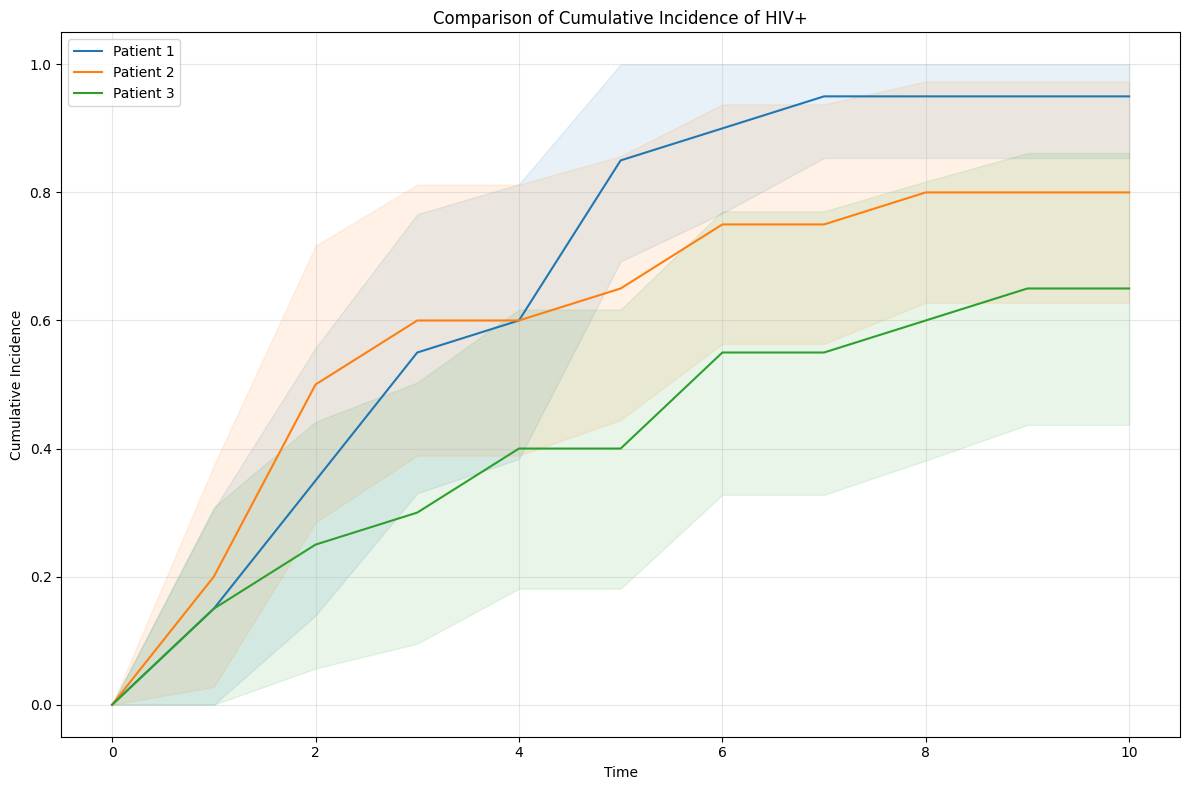

In [16]:
try:
    # Compare CIFs for multiple patients
    n_patients = min(3, len(x_test))
    all_patient_trajectories = []
    
    for i in range(n_patients):
        patient_x = x_test[i:i+1]
        
        patient_trajectories = simulate_patient_trajectory(
            model=model, 
            x=patient_x, 
            start_state=start_state, 
            max_time=max_time, 
            n_simulations=n_simulations,
            seed=42 + i
        )
        
        # Combine all trajectories for this patient
        patient_all_trajectories = pd.concat(patient_trajectories, ignore_index=True)
        patient_all_trajectories['patient_id'] = i
        
        all_patient_trajectories.append(patient_all_trajectories)
    
    combined_trajectories = pd.concat(all_patient_trajectories, ignore_index=True)
    
    # Calculate CIFs for each patient
    patient_cifs = []
    
    for i in range(n_patients):
        patient_data = combined_trajectories[combined_trajectories['patient_id'] == i]
        
        patient_cif = calculate_cif(
            trajectories=patient_data,
            target_state=target_state,
            max_time=max_time
        )
        
        patient_cifs.append(patient_cif)
    
    # Compare CIFs
    fig, ax = compare_cifs(
        cif_list=patient_cifs,
        labels=[f"Patient {i+1}" for i in range(n_patients)],
        title=f"Comparison of Cumulative Incidence of {state_labels[target_state]}"
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error comparing patient CIFs: {e}")

## Simulating Cohort Trajectories

Let's simulate trajectories for a cohort of patients.

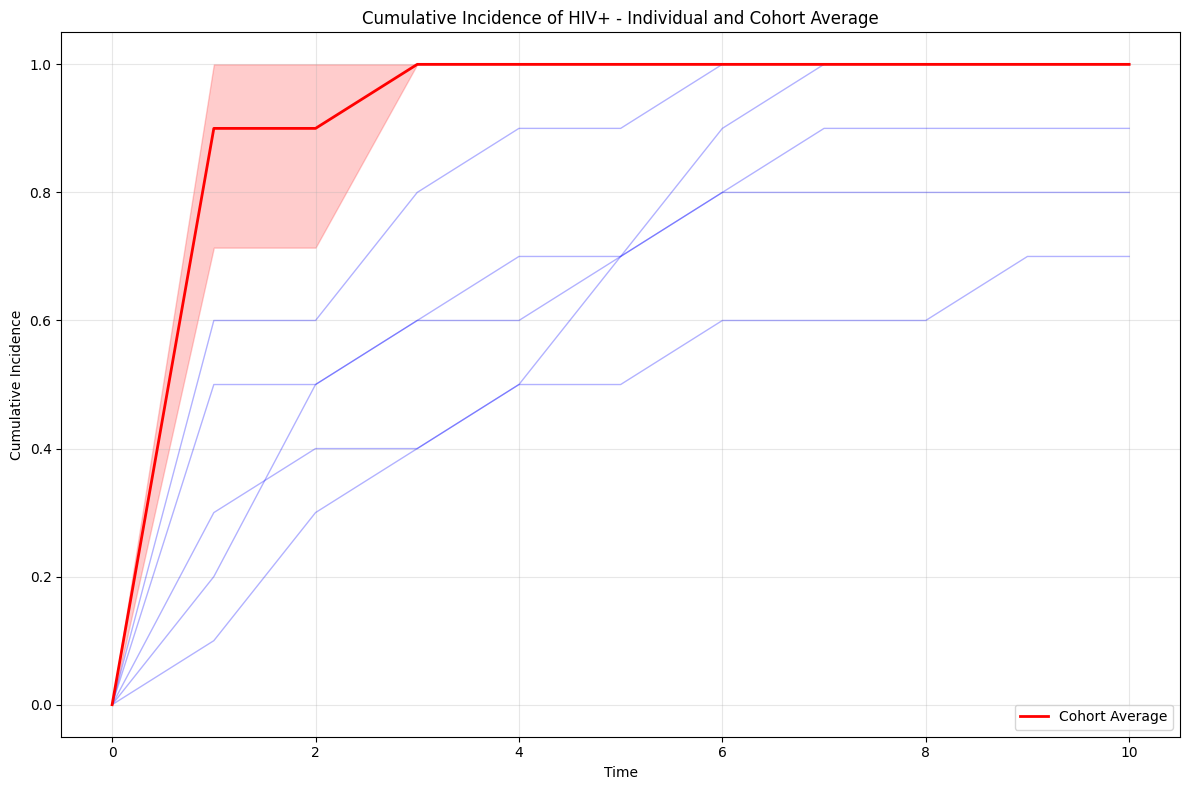

In [17]:
try:
    # Simulate trajectories for the entire cohort
    cohort_trajectories = simulate_cohort_trajectories(
        model=model,
        cohort_features=x_test,
        start_state=start_state,
        max_time=max_time,
        n_simulations_per_patient=10,
        seed=42
    )
    
    # Calculate cohort-level CIF
    cohort_cif = calculate_cif(
        trajectories=cohort_trajectories,
        target_state=target_state,
        max_time=max_time
    )
    
    # Calculate individual patient CIFs
    individual_cifs = calculate_cif(
        trajectories=cohort_trajectories,
        target_state=target_state,
        max_time=max_time,
        by_patient=True
    )
    
    # Plot cohort CIF and individual patient CIFs
    plt.figure(figsize=(12, 8))
    
    # Plot individual patient CIFs
    patient_groups = individual_cifs.groupby('patient_id')
    for patient_id, data in patient_groups:
        plt.plot(data['time'], data['cif'], 'b-', alpha=0.3, linewidth=1)
    
    # Plot cohort average CIF with confidence intervals
    plt.plot(cohort_cif['time'], cohort_cif['cif'], 'r-', linewidth=2, label='Cohort Average')
    plt.fill_between(
        cohort_cif['time'],
        cohort_cif['lower_ci'],
        cohort_cif['upper_ci'],
        color='r',
        alpha=0.2
    )
    
    plt.xlabel('Time')
    plt.ylabel('Cumulative Incidence')
    plt.title(f"Cumulative Incidence of {state_labels[target_state]} - Individual and Cohort Average")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error simulating cohort trajectories: {e}")

## Conclusion

In this notebook, we've demonstrated how to use MultiStateNN with a simulated AIDS dataset to:

1. Prepare and explore multistate data
2. Train a neural network model for predicting state transitions
3. Visualize transition probabilities and state networks
4. Simulate patient trajectories over time
5. Calculate and visualize cumulative incidence functions
6. Compare risks between different patients

The MultiStateNN framework provides a flexible approach for modeling complex multistate processes using neural networks, making it suitable for a wide range of applications in healthcare, finance, and other domains.